# <center> LDA Topic Modelling

In [ ]:
import pandas as pd
import numpy as np
import os
# from itertools import repeat
import re
import collections

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  # don't skip this
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
from wordcloud import WordCloud
import seaborn as sns

######
import spacy
from spacy.tokens import Token, Doc
from gensim.models.phrases import Phrases , Phraser # Gensim bigrams
from spacy.language import Language
from spacy.lang.en.stop_words import STOP_WORDS


##warnings
import psutil 
psutil.cpu_count(logical = False)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
## Data Reddit
data_reddit=pd.read_csv("data_reddit_preprocessed_v2.csv")
data_reddit["source"]="reddit"
data_reddit.drop(columns='Unnamed: 0', inplace=True)
## Data Twitter
data_tweets=pd.read_csv("tweetz.csv")
data_tweets.drop(columns='Unnamed: 0', inplace=True)
data_tweets["source"]="tweets"

#####-------------------------------------------------------------------
all_data=data_reddit.append(data_tweets)
all_data["Q_words"]=all_data.text.apply(lambda x : len(x.split()))
all_data=all_data[all_data.duplicated(subset="text",keep="first")]
all_data.reset_index(drop=True,inplace=True)
all_data

,score,label,text,source,Q_words
0,0.950397,positive,agreed i ve been seeing small groups of friend...,reddit,20
1,0.795385,positive,word cloud out of all the comments fun bot to ...,reddit,17
2,0.795385,positive,word cloud out of all the comments fun bot to ...,reddit,17
3,0.973895,positive,one of my friends brought some cupcakes to cel...,reddit,21
4,-0.910939,negative,please enjoy this i could spend days or hours ...,reddit,30
...,...,...,...,...,...
10735,-0.899951,negative,patients must not be made afraid to say that i...,tweets,18
10736,-0.987890,negative,stress really damages our organs and can kill ...,tweets,20
10737,-0.856955,negative,evil eye dona t even bother me because what go...,tweets,21
10738,-0.910851,negative,the first few months after getting vaccinated ...,tweets,21


In [ ]:
all_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
score,10740.0,-0.702381,0.595617,-0.999908,-0.939438,-0.92992,-0.8726,0.998158
Q_words,10740.0,22.304097,3.705205,16.000000,20.000000,23.00000,24.0000,210.000000


In [ ]:
print(all_data[all_data['source']=='tweets'].describe().transpose())
print(all_data[all_data['source']=='reddit'].describe().transpose())

           count       mean       std        min        25%        50%  \
score    10720.0  -0.702622  0.595317  -0.999908  -0.939438  -0.929718   
Q_words  10720.0  22.274254  3.197217  16.000000  20.000000  23.000000   

             75%        max  
score    -0.8726   0.998158  
Q_words  24.0000  53.000000  
         count       mean        std        min       25%        50%  \
score     20.0  -0.572962   0.746539  -0.999547  -0.94506  -0.931361   
Q_words   20.0  38.300000  41.505992  16.000000  23.25000  28.500000   

               75%         max  
score    -0.875801    0.973895  
Q_words  36.500000  210.000000  


In [ ]:
# all_data=all_data[all_data['source']=='reddit']
# all_data.shape

## Preprocessing for LDA

In [ ]:
#Remove no textual characters
def regex_spacy(text):
    #Realizar antes de tokenizar porque spacy tokeniza mal algunas palabras con este inconveniente
    #new_text = re.sub(r'0001[Ff]\d+|0001[Ff]\d[Ff][Ff]',' ', text).strip()
   # new_text = re.sub(r'0001[Ff]\d+[a-zA-Z]',' ', new_text).strip()
    new_text = re.sub(r'0001[a-zA-Z]\d+[a-zA-Z]|0001[a-zA-Z]\d+|0001[a-zA-Z]\d[a-zA-Z][a-zA-Z]',' ', text).strip()
    new_text = re.sub(r'06[a-z][a-z]|06\d[a-z]',' ', new_text).strip()
    if new_text=="":
        return ' '
    else:
        return new_text

In [ ]:
@Language.component("replace_words_doc")
# Define the function that takes a doc and replace some specific words, like contractions or abbreviations
def replace_words_doc(doc):
    replace_doc=[]
    spacesD=[]
    for token in doc:
        #detectar si es una palabra a reemplazar
        if token.text in dictionary_words.keys():
            n_word=dictionary_words[token.text].split()
            replace_doc.extend(n_word)
        else:
            replace_doc.append(token.text)
    
    for i in range(len(replace_doc)):
        spacesD.append(True)
        
    ##output a Doc spacy object
    spacesD[-1]=False
    #print(lemma_doc,"\n",spacesD)
    return Doc(doc.vocab, words=replace_doc,spaces=spacesD)

In [ ]:
@Language.component("lemmatizer_doc")
# Define the function that takes a doc and performs lemmatization it
def lemmatizer_doc(doc):
    lemma_doc=[]
    spacesD=[]
    for token in doc:
        lemma_doc.append(token.lemma_)
        spacesD.append(True)
    
    ##output a Doc spacy object
    spacesD[-1]=False
    #print(lemma_doc,"\n",spacesD)
    return Doc(doc.vocab, words=lemma_doc,spaces=spacesD)

In [ ]:
@Language.component("preproc_doc")
# Define the function that takes a doc and performs most of the cleaning and remove stop_words
def preproc_doc(doc):
    preproc_doc=[]
    spacesD=[]
    for token in doc:
        if token.is_punct==False and token.like_num==False and token.is_digit==False and token.is_space==False and token.is_currency==False and token.like_url==False and not token.is_stop and token.text != '-PRON-' and len(token.text)>2:
            preproc_doc.append(token.text)
            spacesD.append(True)
    
    if preproc_doc==[]:
        return Doc(doc.vocab, words=["No_words"],spaces=[False])
    else:
        ##output a Doc spacy object
        spacesD[-1]=False
        #print(lemma_doc,"\n",spacesD)
        return Doc(doc.vocab, words=preproc_doc,spaces=spacesD)

In [ ]:
def all_text_data_preproc(dataset):
    '''
    Main function to perform preprocessing
    '''
    clean_data=dataset.apply(regex_spacy)
    news_doc=nlp.pipe(clean_data.to_numpy())
    print("Pipeline Done")

    return pd.Series([docs.text for docs in news_doc],name="Text_clean",dtype='object',index=dataset.index)

## Build Pipeline

In [ ]:
###Loading spacy model
nlp = spacy.load('en_core_web_md', disable=["parser","ner"])#"ner",
print('spaCy Version: %s' % (spacy.__version__))
##add customize pipe
nlp.add_pipe('replace_words_doc', first=True)
# nlp.add_pipe('clean_doc', before='tok2vec')
nlp.add_pipe('lemmatizer_doc', last=True)
nlp.add_pipe('preproc_doc', last=True)
print(nlp.pipe_names)

spaCy Version: 3.0.6
['replace_words_doc', 'tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer', 'lemmatizer_doc', 'preproc_doc']


#### Replace words lists

In [ ]:
dictionary_words={'anxious':'anxiety', 'stresseda':'stressed', 'don':"do not", 'dona':"do not", 'didn':"did not", "anxiousa":"anxiety"}
## D.C. de washington dc
dictionary_words

{'anxious': 'anxiety',
 'stresseda': 'stressed',
 'don': 'do not',
 'dona': 'do not',
 'didn': 'did not',
 'anxiousa': 'anxiety'}

#### Customized stopwords

In [ ]:
##ADD CUSTOMIZE Stop words
customize_stop_words = [
    'ita', 'people', 'amp','lac','fe0f','200d', 'hello', 'ripley', 'indian', 'thena'
]
#'064a','062a','062f', 'blanket', 'thena', 'ripley', 'push', 'know', 'hello', 'time', 'think'
for w in customize_stop_words:
    nlp.vocab[w].is_stop = True

In [ ]:
# aca=[[{'score': 0.871151, 'tone_id': 'joy', 'tone_name': 'Joy'},
#  {'score': 0.515711, 'tone_id': 'tentative', 'tone_name': 'Tentative'}],
# [{'score': 0.871151, 'tone_id': 'joy', 'tone_name': 'Joy'},
#  {'score': 0.515711, 'tone_id': 'tentative', 'tone_name': 'Tentative'},
#  {'score': 0.990104, 'tone_id': 'tentative', 'tone_name': 'AJA'}]]
# aca

In [ ]:
# pd.json_normalize(aca)

### Clean data

In [ ]:
# ###copy of text data
# data_spacy=all_data['text'].copy() ##copy News_data
# data_spacy.shape

In [ ]:
%%time
news_doc_spacy=all_text_data_preproc(all_data['text'])
#10min#6min#3min

Pipeline Done
Wall time: 15.9 s


## Data Viz 

In [ ]:
def plot_wordCloud_CommonWords(text_data):
    '''
    Input must be a whole text (str) not a list
    '''

    ##PLOT WORDCLOUD
    print("Text")
    pos_cloud1 = WordCloud(background_color="black", max_words=500,
                            random_state=50,width=2000,height=1000,relative_scaling=0,collocations=False).generate(text_data)
    ##PLOT WORDCLOUD
    plt.figure( figsize=(20,10) )
    #plot.title()
    plt.imshow(pos_cloud1)
    plt.axis("off")
    plt.show()
    
    print("\n")
    ##PLOT MOST COMMON WORDS-----------------
    news_counts=collections.Counter(text_data.split())

    # Plot top 25 most frequently words
    common_words_news = [word[0] for word in news_counts.most_common(25)]
    common_words_news_count = [word[1] for word in news_counts.most_common(25)]

    # Use spooky background
    #plt.style.use('dark_background')
    plt.figure(figsize=(15, 12))

    sns.barplot(x=common_words_news, y=common_words_news_count)
    plt.title('Most Common Words (top 25)')
    plt.xticks(rotation=70)
    plt.show()

Text


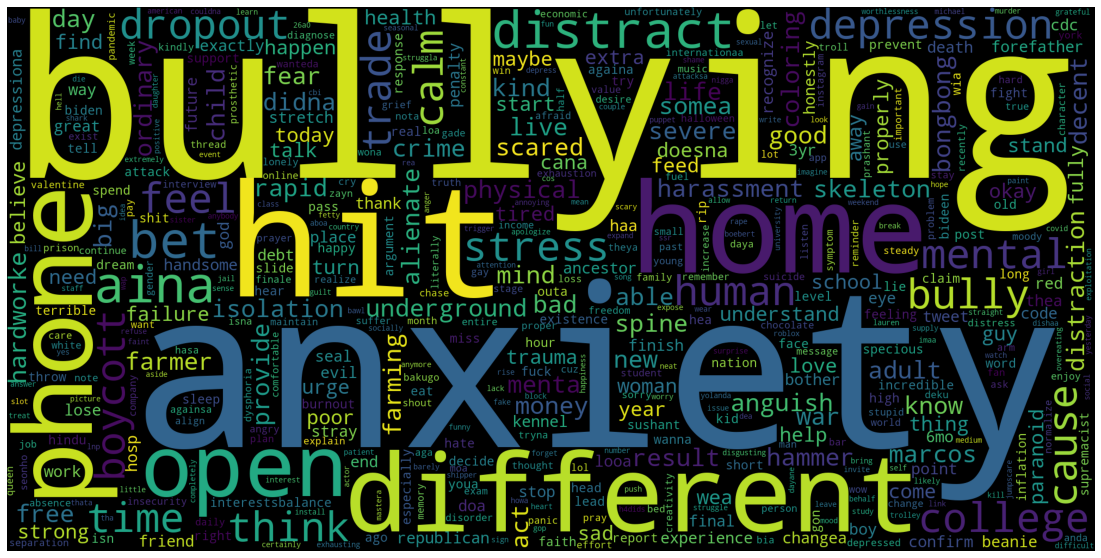

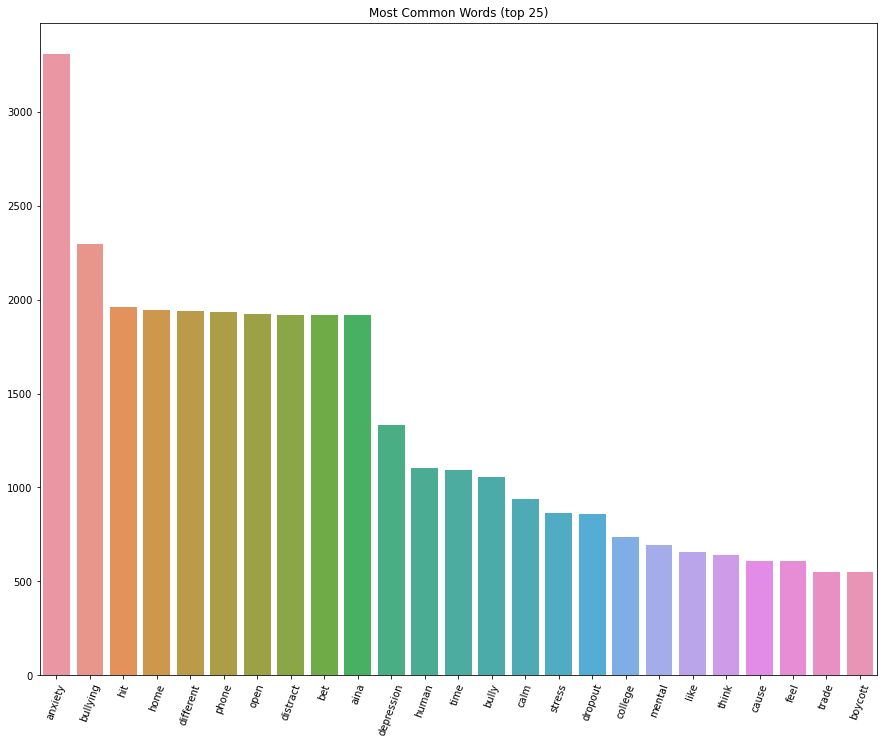

Wall time: 7.8 s


In [ ]:
%%time
plot_wordCloud_CommonWords(" ".join(news_doc_spacy))

## Creating the dictionary and corpus for topic modeling

In [ ]:
def create_dict_corpus(text_data):
    # Corpus
    data_clean_tokens1=text_data.apply(lambda x: str(x).split(' '))

    # ID_word
    # Create Dictionary # id2word
    dictionary_crt = corpora.Dictionary(data_clean_tokens1)
    #print(len(dictionary))


    # Term Document Frequency
    bow_crt = data_clean_tokens1.apply(lambda x: dictionary_crt.doc2bow(x))
    
    return dictionary_crt, bow_crt, data_clean_tokens1

# Build LDA

## Optimize # of k topics

In [ ]:
def compute_coherence_values(id2word, corpus, texts, limit, start=3, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    ##LDA params
    params={"random_state":100,"workers":5,"chunksize":4000}
    ##model init
    Lda_Multi = gensim.models.ldamulticore.LdaMulticore
    
    coherence_values = []
    model_list = []
    best_score=0
    best_num=0
    
    for k in tqdm(range(start, limit, step)):
        
        ldamodel = Lda_Multi(corpus=corpus,
                           id2word=id2word,
                           num_topics=k, 
                           random_state=params["random_state"],
                           workers=params["workers"],
                           chunksize=params["chunksize"])
        
        model_list.append(ldamodel)
        coherencemodel = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=texts,dictionary=id2word, coherence='c_v')
        c_value=coherencemodel.get_coherence()
        coherence_values.append(c_value)
        
        if c_value>best_score:
            best_score=c_value
            best_num=k
    
    ##plot graph
    # Show graph
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    
    return model_list, coherence_values, best_num

In [ ]:
### SAVE DATA
all_data["proc_spacy"]=news_doc_spacy
# all_data.reset_index().to_json('Dataset_reddit_spacy.json',orient='records', force_ascii=True)

In [ ]:
dictionary, bow, data_clean_tokens=create_dict_corpus(all_data["proc_spacy"])

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [05:07<00:00, 17.09s/it]


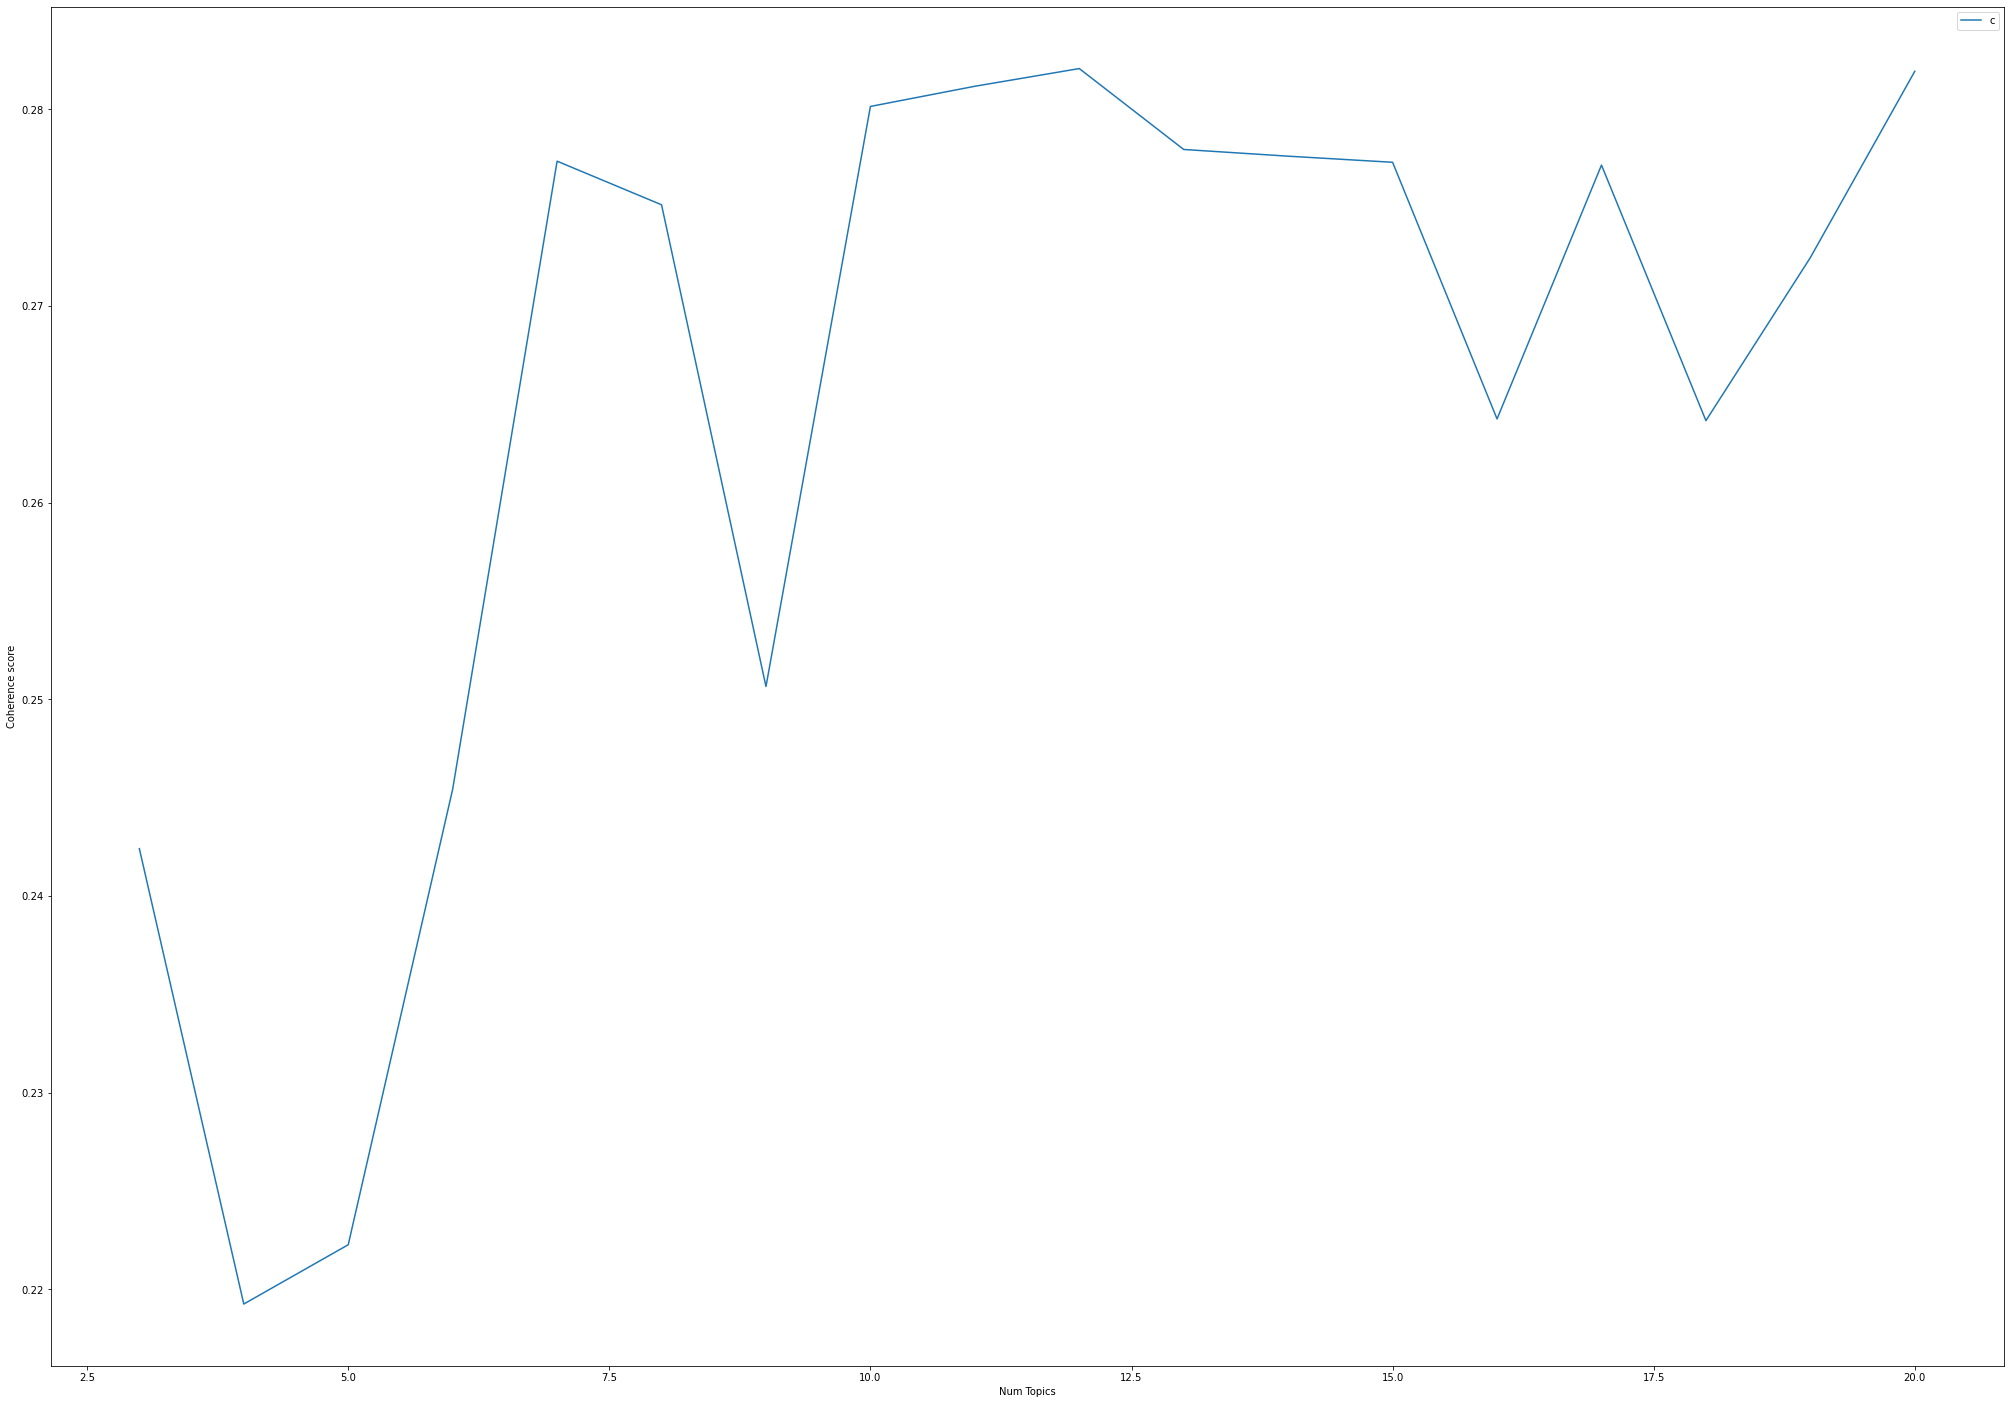

In [ ]:
models,coherence_list, best_numTopics=compute_coherence_values(dictionary, bow, data_clean_tokens, 21, start=3, step=1)

In [ ]:
# Print the coherence scores
for m, cv in zip(range(3, 21), coherence_list):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 3  has Coherence Value of 0.2424
Num Topics = 4  has Coherence Value of 0.2192
Num Topics = 5  has Coherence Value of 0.2223
Num Topics = 6  has Coherence Value of 0.2454
Num Topics = 7  has Coherence Value of 0.2774
Num Topics = 8  has Coherence Value of 0.2752
Num Topics = 9  has Coherence Value of 0.2507
Num Topics = 10  has Coherence Value of 0.2802
Num Topics = 11  has Coherence Value of 0.2812
Num Topics = 12  has Coherence Value of 0.2821
Num Topics = 13  has Coherence Value of 0.278
Num Topics = 14  has Coherence Value of 0.2776
Num Topics = 15  has Coherence Value of 0.2773
Num Topics = 16  has Coherence Value of 0.2643
Num Topics = 17  has Coherence Value of 0.2772
Num Topics = 18  has Coherence Value of 0.2642
Num Topics = 19  has Coherence Value of 0.2725
Num Topics = 20  has Coherence Value of 0.2819


### Build models

In [ ]:
def optimal_LDA_model(num_topics, texts, id2word, corpus):
    # Build LDA model

    ##LDA params
    params={"random_state":100,"workers":5,"chunksize":4000}#

    ##model init
    Lda_Multi = gensim.models.ldamulticore.LdaMulticore

    lda_model_1 = Lda_Multi(corpus=corpus,
                       id2word=id2word,
                       num_topics=num_topics, 
                       random_state=params["random_state"],
                       workers=params["workers"],
                       chunksize=params["chunksize"])

    cm2 = gensim.models.coherencemodel.CoherenceModel(model=lda_model_1, texts=texts, dictionary=id2word, coherence='c_v')
    print(f'Coherence: {cm2.get_coherence()}')
    return lda_model_1

### Viz topics in wordcloud

In [ ]:
def Wordcloud_topics(n_topics,model,q_subplots, save_path):
    topics = [[(term, round(wt, 3)) for term, wt in model.show_topic(n, topn=30)] for n in range(0, model.num_topics)]
    topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, model.num_topics+1)] )
    # initiate wordcloud object
    wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

    # set the figure size
    plt.rcParams['figure.figsize'] = [35, 25]

    # Create subplots for each topic
    for i in range(n_topics):

        wc.generate(text=topics_df["Terms per Topic"][i])

        plt.subplot(6, q_subplots, i+1)
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(topics_df.index[i], fontsize=15)
    #save figure 
    plt.savefig(save_path, bbox_inches='tight')
    ##show
    plt.show()

In [ ]:
lda_model=optimal_LDA_model(7, data_clean_tokens, dictionary, bow)

Coherence: 0.2773675284818597


In [ ]:
lda_model.show_topics(num_topics=2, num_words=50, log=False, formatted=True)

[(4,
  '0.026*"bully" + 0.021*"depression" + 0.019*"money" + 0.019*"anxiety" + 0.018*"big" + 0.018*"act" + 0.018*"decent" + 0.018*"farmer" + 0.018*"ordinary" + 0.018*"farming" + 0.018*"hardworke" + 0.018*"war" + 0.012*"republican" + 0.011*"today" + 0.010*"new" + 0.008*"feed" + 0.008*"feel" + 0.008*"year" + 0.007*"school" + 0.007*"like" + 0.007*"poor" + 0.007*"place" + 0.007*"great" + 0.007*"kind" + 0.006*"think" + 0.006*"nation" + 0.006*"claim" + 0.005*"need" + 0.005*"thank" + 0.005*"bullying" + 0.005*"support" + 0.005*"death" + 0.005*"company" + 0.005*"harassment" + 0.005*"york" + 0.005*"align" + 0.005*"hasa" + 0.004*"value" + 0.004*"outa" + 0.004*"prevent" + 0.004*"slide" + 0.004*"biden" + 0.004*"bideen" + 0.004*"help" + 0.004*"inflation" + 0.004*"depressiona" + 0.004*"rip" + 0.004*"response" + 0.004*"prison" + 0.004*"cry"'),
 (3,
  '0.047*"anxiety" + 0.025*"mental" + 0.023*"cause" + 0.022*"kind" + 0.022*"result" + 0.022*"severe" + 0.021*"rapid" + 0.021*"isolation" + 0.021*"physical"

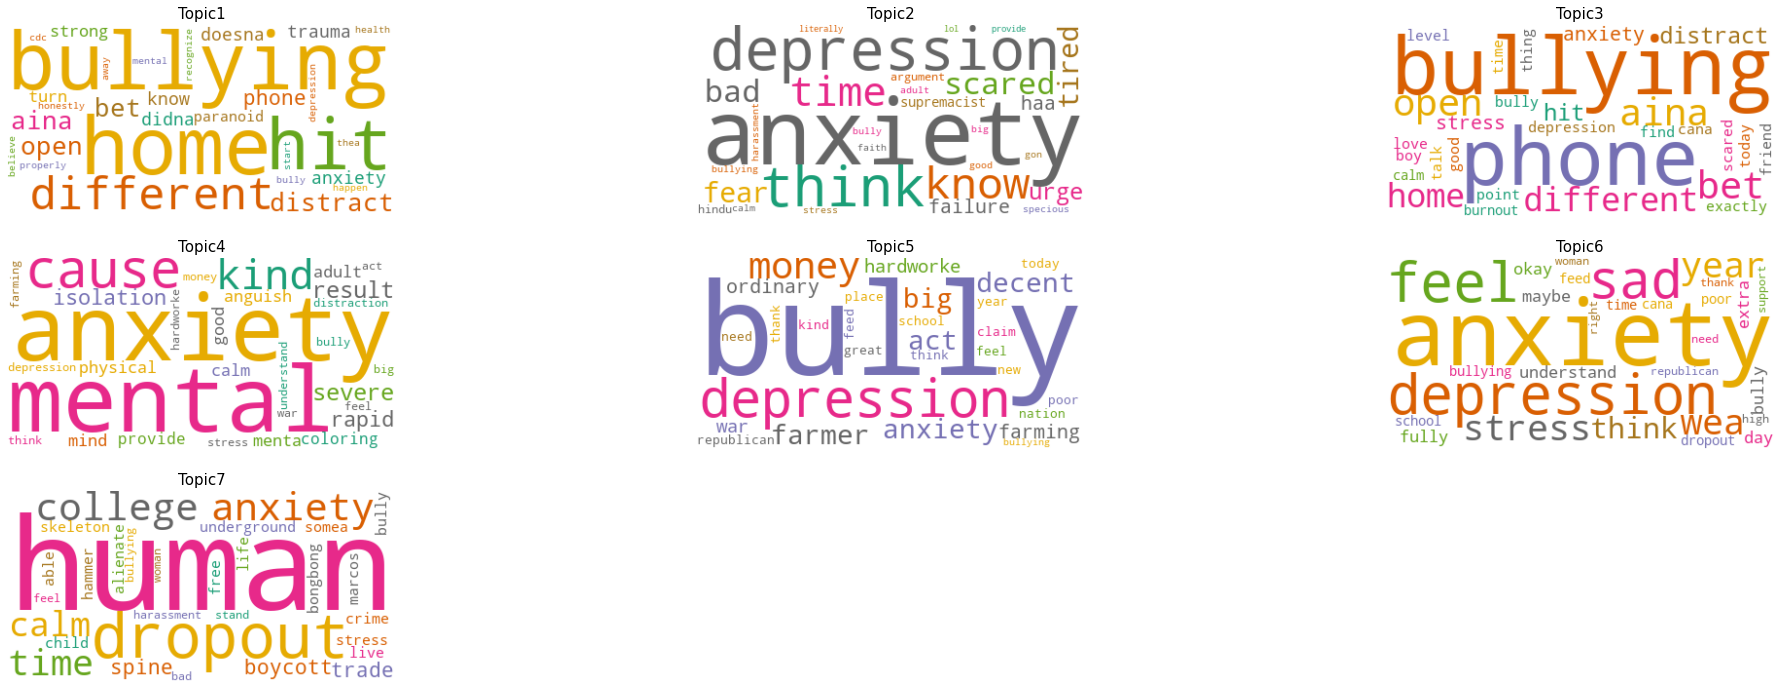

In [ ]:
Wordcloud_topics(7,lda_model,3,"Wordcloud_7_topicsVF.png")

#### Visualize topics

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, bow, dictionary)
pyLDAvis.save_html(vis, 'lda_7VF.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.232718  0.009861       1        1  23.003126
6      0.025345 -0.265728       2        1  17.038691
3      0.133908  0.110738       3        1  16.385031
5      0.115373  0.024988       4        1  12.476594
4      0.126585  0.073964       5        1  12.140677
1      0.079238 -0.020202       6        1   9.575347
0     -0.247732  0.066378       7        1   9.380534, topic_info=            Term         Freq        Total Category  logprob  loglift
1058   different  1724.000000  1724.000000  Default  30.0000  30.0000
2114    distract  1702.000000  1702.000000  Default  29.0000  29.0000
2112        aina  1722.000000  1722.000000  Default  28.0000  28.0000
2113         bet  1722.000000  1722.000000  Default  27.0000  27.0000
154         open  1738.000000  1738.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
153         away    46.435909   112.075922   Topic7  -5.3147   1.4854
157   depression    87.382550  1422.999521   Topic7  -4.6825  -0.4237
291       health    48.290015   205.355205   Topic7  -5.2755   0.9190
539        bully    59.858895  1083.197188   Topic7  -5.0608  -0.5291
305       mental    54.986842   572.882282   Topic7  -5.1457   0.0229

[500 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
2834      1  0.884164  26a0
2834      6  0.095585  26a0
722       1  0.047158  able
722       2  0.864565  able
722       3  0.003930  able
...     ...       ...   ...
66        7  0.018004  year
2147      1  0.026080  york
2147      4  0.130398  york
2147      5  0.717187  york
2147      6  0.130398  york

[1328 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 4, 6, 5, 2, 1])

### Save LDA models

In [ ]:
from gensim.test.utils import datapath

path_model=os.path.join(os.getcwd(), "LDA_models","ModelVF_7topics")
# Save model to disk.
temp_file = datapath(path_model)
lda_model.save(temp_file)

##SAVE MODEL 2

# path_model=os.path.join(os.getcwd(), "LDA_models","Model_8topics")
# # Save model to disk.
# temp_file = datapath(path_model)
# lda_model2.save(temp_file)

# Load a potentially pretrained model from disk.
#lda = LdaModel.load(temp_file)

In [ ]:
# from gensim.test.utils import datapath
# path_model=os.path.join(os.getcwd(), "LDA_models","Iteration_5","Model_10topicsv2")
# lda_model_load = gensim.models.ldamulticore.LdaMulticore.load(path_model)

## Add principal topic and its distribution for each document

In [ ]:
def format_topics_keywords(dataset,modelo_lda, termFreq):
    frame=pd.DataFrame()
    ##get dominant_topic
    frame["Dominant_Topic"]=termFreq.apply(lambda y: sorted(modelo_lda.get_document_topics(y), key=lambda x: (x[1]), reverse=True)[0][0]+1)##+1 para que no haya el topic 0
    #print("D_topic\n",frame[['Dominant_Topic']].head())
    ##add its perc_contribution
    frame['Perc_Contribution']=termFreq.apply(lambda y: round(sorted(modelo_lda.get_document_topics(y), key=lambda x: (x[1]), reverse=True)[0][1],4))
    #print("P_topic")
    ##add key words per dominant_topic
    Topics_Keywords=pd.DataFrame({'Dominant_Topic':frame['Dominant_Topic'].unique()})
    #print(Topics_Keywords)
    Topics_Keywords['Topic_Keywords']=Topics_Keywords['Dominant_Topic'].apply(lambda x: ", ".join([word for word, prop in modelo_lda.show_topic(x-1)]))
    ##Labeling topics
    Topics_Keywords["Label_Topic"] = Topics_Keywords["Dominant_Topic"].map({1: "Home Conflicts/Bullying",
                                                                           2: "Depression/Anxiety",
                                                                           3: "Bullying",
                                                                           4: "Mental Health/Anxiety",
                                                                           5: "Depression/Bullying",
                                                                           6: "Sadness/Depression/Anxiety",
                                                                           7: "College anxiety/ Dropout"
                                                                          })

    
    frame=pd.merge(frame,Topics_Keywords, on="Dominant_Topic", how="inner",right_index=True).sort_index()
    #data.join(Topics_Keywords, on="Dominant_Topic", how="inner", rsuffix='_other')
    return pd.concat([dataset,frame], axis=1)

Wall time: 0 ns


In [ ]:
%%time
data=format_topics_keywords(all_data,lda_model2, bow)
##print
data.head()#[['source','Dominant_Topic','Perc_Contribution','Topic_Keywords','proc_spacy']].head(5)

Wall time: 48.8 s


,score,label,text,source,Q_words,proc_spacy,Dominant_Topic,Perc_Contribution,Topic_Keywords
0,0.882554,positive,i have 8 assignments due by monday what s the ...,reddit,20,assignment monday weekend anyways ahaha gon kms,10,0.4665,"man, kill, wife, stress, year, stressed, lockd..."
1,0.934563,positive,ok listen im class of 2024 and now i can t hit...,reddit,19,listen class hit woah grade dance,6,0.5393,"push, hunger, poverty, remember, ban, want, an..."
2,0.820578,positive,actually it s still the left calculator and th...,reddit,25,actually left calculator rest structure head l...,14,0.9151,"dropout, work, stress, time, think, anxiety, f..."
3,0.838078,positive,yeahhh i didn t study and gor an 1140 the firs...,reddit,43,yeahhh study gor time high score 2nd time stud...,7,0.5530,"time, think, stress, feel, like, good, life, a..."
4,0.980824,positive,eh if your smart enough you should easily be a...,reddit,29,smart easily able pretty good school practice ...,9,0.8963,"like, anxiety, feel, stress, thing, know, cana..."


In [ ]:
all_data.label + " " +  all_data.text 

0        positive agreed i ve been seeing small groups ...
1        positive word cloud out of all the comments fu...
2        positive word cloud out of all the comments fu...
3        positive one of my friends brought some cupcak...
4        negative please enjoy this i could spend days ...
                               ...                        
10735    negative patients must not be made afraid to s...
10736    negative stress really damages our organs and ...
10737    negative evil eye dona t even bother me becaus...
10738    negative the first few months after getting va...
10739    negative evil eye dona t even bother me becaus...
Length: 10740, dtype: object

In [ ]:
#save file
data.reset_index().to_json('LDA_Data.json',orient = "records", force_ascii=True)